In [129]:
import pandas as pd
import numpy as np
from numpy import argmax
import matplotlib.pyplot as plt
%matplotlib inline
import librosa
import librosa.display
import IPython.display
import random
import warnings
import os
from PIL import Image
import pathlib
import csv
# sklearn Preprocessing
from sklearn.model_selection import train_test_split
#Keras
import keras
import warnings
warnings.filterwarnings('ignore')
from keras import layers
from keras.layers import Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, Input, Add
from keras.models import Sequential
from keras.optimizers import SGD

SystemError: <built-in method write of _io.BufferedWriter object at 0x00000230BE646A98> returned a result with an error set

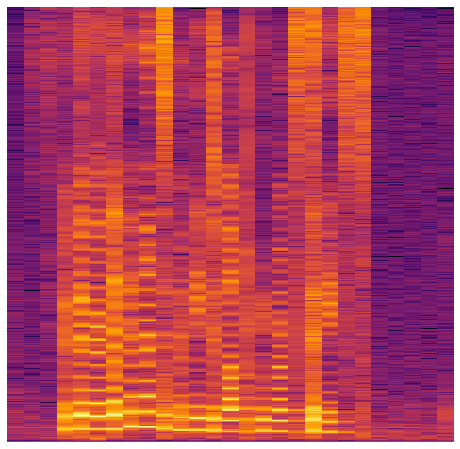

In [105]:
cmap = plt.get_cmap('inferno')
plt.figure(figsize=(8,8))
genres = 'kannada english'.split()
songname=list()
filelist = os.listdir('./english') # folder containing audio files
for file in filelist:
    if(file.endswith('.wav')):
          songname.append('./english/'+file)
#for g in genres:
pathlib.Path(f'img_data').mkdir(parents=True, exist_ok=True)
for song in songname:   
    sr, y = scipy.io.wavfile.read(song)
    plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
    plt.axis('off');
    plt.savefig(f'./img_data/{song[:-3].replace(".", "")}.png')
    plt.clf()

In [130]:
import split_folders
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
split_folders.ratio('./img_data/', output="./data", seed=1337, ratio=(.8, .2)) # default values

Copying files: 1169 files [00:03, 358.05 files/s]


In [131]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale=1./255, # rescale all pixel values from 0-255, so aftre this step all our pixel values are in range (0,1)
        shear_range=0.2, #to apply some random tranfromations
        zoom_range=0.2, #to apply zoom
        horizontal_flip=True) # image will be flipper horiz
test_datagen = ImageDataGenerator(rescale=1./255)

In [132]:
training_set = train_datagen.flow_from_directory(
        './data/train',
        target_size=(64, 64),
        batch_size=32,
        class_mode='categorical',
        shuffle = False)
test_set = test_datagen.flow_from_directory(
        './data/val',
        target_size=(64, 64),
        batch_size=32,
        class_mode='categorical',
        shuffle = False )


Found 935 images belonging to 2 classes.
Found 234 images belonging to 2 classes.


In [139]:
model = Sequential()
input_shape=(64, 64, 3)
#1st hidden layer
model.add(Conv2D(32, (3, 3), strides=(2, 2), input_shape=input_shape))
model.add(AveragePooling2D((2, 2), strides=(2,2)))
model.add(Activation('relu'))
#2nd hidden layer
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(AveragePooling2D((2, 2), strides=(2,2)))
model.add(Activation('relu'))
#3rd hidden layer
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(AveragePooling2D((2, 2), strides=(2,2)))
model.add(Activation('relu'))
#Flatten
model.add(Flatten())
model.add(Dropout(rate=0.5))
#Add fully connected layer.
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))
#Output layer
model.add(Dense(2))
model.add(Activation('softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 31, 31, 32)        896       
_________________________________________________________________
average_pooling2d_4 (Average (None, 15, 15, 32)        0         
_________________________________________________________________
activation_6 (Activation)    (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
average_pooling2d_5 (Average (None, 7, 7, 64)          0         
_________________________________________________________________
activation_7 (Activation)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 64)         

In [140]:
epochs = 200
batch_size = 8
learning_rate = 0.01
decay_rate = learning_rate / epochs
momentum = 0.9
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
model.compile(optimizer="sgd", loss="categorical_crossentropy", metrics=['accuracy'])

In [142]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [143]:
model.fit_generator(
        training_set,
        steps_per_epoch=100,
        epochs=10,
        validation_data=test_set,
        validation_steps=200)

Epoch 1/10
100/100 [==============================] - 63s 629ms/step - loss: 0.6597 - accuracy: 0.6461 - val_loss: 1.0898 - val_accuracy: 0.6325
Epoch 2/10
100/100 [==============================] - 61s 608ms/step - loss: 0.6612 - accuracy: 0.6134 - val_loss: 0.8090 - val_accuracy: 0.6325
Epoch 3/10
100/100 [==============================] - 62s 622ms/step - loss: 0.6188 - accuracy: 0.6387 - val_loss: 0.6669 - val_accuracy: 0.8932
Epoch 4/10
100/100 [==============================] - 63s 626ms/step - loss: 0.5523 - accuracy: 0.7184 - val_loss: 0.6322 - val_accuracy: 0.8333
Epoch 5/10
100/100 [==============================] - 63s 632ms/step - loss: 0.4714 - accuracy: 0.8058 - val_loss: 0.5497 - val_accuracy: 0.8333
Epoch 6/10
100/100 [==============================] - 70s 700ms/step - loss: 0.3865 - accuracy: 0.8746 - val_loss: 0.2174 - val_accuracy: 0.9487
Epoch 7/10
100/100 [==============================] - 73s 728ms/step - loss: 0.3029 - accuracy: 0.8992 - val_loss: 0.1371 - val_ac

In [144]:
model.evaluate_generator(generator=test_set, steps=50)

[0.003745434805750847, 0.9550408720970154]

In [145]:
test_set.reset()
pred = model.predict_generator(test_set, steps=50, verbose=1)

50/50 [==============================] - 10s 205ms/step


In [146]:
predicted_class_indices=np.argmax(pred,axis=1)

labels = (training_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
filenames=test_set.filenames
predictions = predictions[:len(filenames)]

In [147]:
print(len(filenames), len(predictions))

234 234


In [148]:
results=pd.DataFrame({"Filename":filenames,"Predictions":predictions})
print(results)
#results.to_csv("prediction_results.csv",index=False)

                              Filename Predictions
0     english\f0001_us_f0001_00013.png     english
1     english\f0001_us_f0001_00018.png     english
2     english\f0001_us_f0001_00019.png     english
3     english\f0001_us_f0001_00026.png     english
4     english\f0001_us_f0001_00031.png     english
5     english\f0001_us_f0001_00041.png     english
6     english\f0001_us_f0001_00044.png     english
7     english\f0001_us_f0001_00045.png     english
8     english\f0001_us_f0001_00047.png     english
9     english\f0001_us_f0001_00052.png     english
10    english\f0001_us_f0001_00055.png     english
11    english\f0001_us_f0001_00056.png     english
12    english\f0001_us_f0001_00058.png     english
13    english\f0001_us_f0001_00061.png     english
14    english\f0001_us_f0001_00067.png     english
15    english\f0001_us_f0001_00069.png     english
16    english\f0001_us_f0001_00071.png     english
17    english\f0001_us_f0001_00074.png     english
18    english\f0001_us_f0001_00

In [159]:
from keras.models import load_model

model.save('my_model.h5')

In [168]:
from keras.models import load_model
model = load_model('./my_model.h5')

In [ ]:
from keras.models import load_model
import cv2
import numpy as np

model = load_model('my_model.h5')

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

img = cv2.imread('test.jpg')
img = cv2.resize(img,(320,240))
img = np.reshape(img,[1,320,240,3])

classes = model.predict_classes(img)

print classes

In [163]:
# Convert into Numpy array
samples_to_predict='./img_data/kannada/knm_00574_01580044512.png'

samples_to_predict = np.array(samples_to_predict)
print(samples_to_predict.shape)

# Generate predictions for samples
predictions = model.predict(samples_to_predict)
print(predictions)

()


ValueError: Error when checking input: expected conv2d_4_input to have 4 dimensions, but got array with shape ()